In [1]:
import kagglehub
import pandas as pd
import json
import tqdm
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [32]:
cities_bussiness_count = {} # dictionary to store the city names and their corresponding business counts
cities_review_count = {} # dictionary to store the city names and their corresponding review counts
city_names = [] # list to store the names of the cities

In [3]:
# Download latest version
path = kagglehub.dataset_download("yelp-dataset/yelp-dataset")
# Load the dataset
business_path = path + "/yelp_academic_dataset_business.json"
print(business_path)

/home/dzz/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4/yelp_academic_dataset_business.json


In [33]:
open_file = open(business_path, "r", encoding="utf-8")
for i in tqdm.tqdm(range(150346)):
    line = open_file.readline()
    # convert to pandas dataframe
    data = json.loads(line)
    # check if the city is in the dictionary
    if data["city"] in cities_bussiness_count:
        cities_bussiness_count[data["city"]] += 1
        cities_review_count[data["city"]] += data["review_count"]
    else:
        city_names.append(data["city"])
        cities_bussiness_count[data["city"]] = 1
        cities_review_count[data["city"]] = data["review_count"]

100%|██████████| 150346/150346 [00:01<00:00, 84060.09it/s]


In [28]:
## 处理城市名混淆问题
print(city_names)
device = "cpu"
print(f"Using device: {device}")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2',device=device)
embeddings = model.encode(city_names,convert_to_tensor=True,device=device)
embeddings_np = embeddings.cpu().numpy()

# Perform Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters=None,metric='cosine', distance_threshold=0.20,linkage='average')
labels = clustering.fit_predict(embeddings_np)

alias_dict = {}
clusters = {}

# Create a dictionary to store the clusters
for label,city in zip(labels,city_names):
    clusters.setdefault(label, []).append(city)

# Create a dictionary to store the alias names
for cluster in clusters.values():
    # 用最短的城市名作为别名
    canonical_name = min(cluster, key=len)
    for alias in cluster:
        alias_dict[alias] = canonical_name

# output the alias dict to csv
alias_df = pd.DataFrame.from_dict(alias_dict, orient='index', columns=['canonical_name'])
alias_df.index.name = 'alias_name'
alias_df.reset_index(inplace=True)
alias_df.to_csv("alias_dict.csv", index=False)
    

['Santa Barbara', 'Affton', 'Tucson', 'Philadelphia', 'Green Lane', 'Ashland City', 'Brentwood', 'St. Petersburg', 'Nashville', "Land O' Lakes", 'Tampa Bay', 'Indianapolis', 'Clearwater', 'Largo', 'New Orleans', 'Kenner', 'Edmonton', 'Reno', 'Newtown', 'White House', 'Boise', 'Paoli', 'Ardmore', 'Exton', 'Wilmington', 'Edwardsville', 'Sparks', 'Alton', 'Cherry Hill', 'Bala Cynwyd', 'Springfield', 'Belleville', 'Carmel', 'Tampa', 'Kennett Square', 'Plymouth Meeting', 'Harvey', 'West Chester', 'Meridian', 'Hudson', 'Fernley', 'Williamstown', 'Pinellas Park', 'Glenolden', 'Wesley Chapel', 'Fishers', 'Burlington', 'Troy', 'Camden', 'Plainfield', 'Bensalem', 'Maplewood', 'Saint Louis', 'Fairview Heights', 'Oro Valley', 'Treasure Island', 'Southampton', 'Chalfont', 'Willow Grove', 'Voorhees', 'Tarpon Springs', 'Blue Bell', 'Metairie', 'Woodbury', 'Brownsburg', 'Norristown', 'Land O Lakes', 'Greenwood', 'Saint Petersburg', 'Brookhaven', 'Haverford', 'Glenside', 'Moorestown', 'Madison', 'Ewing

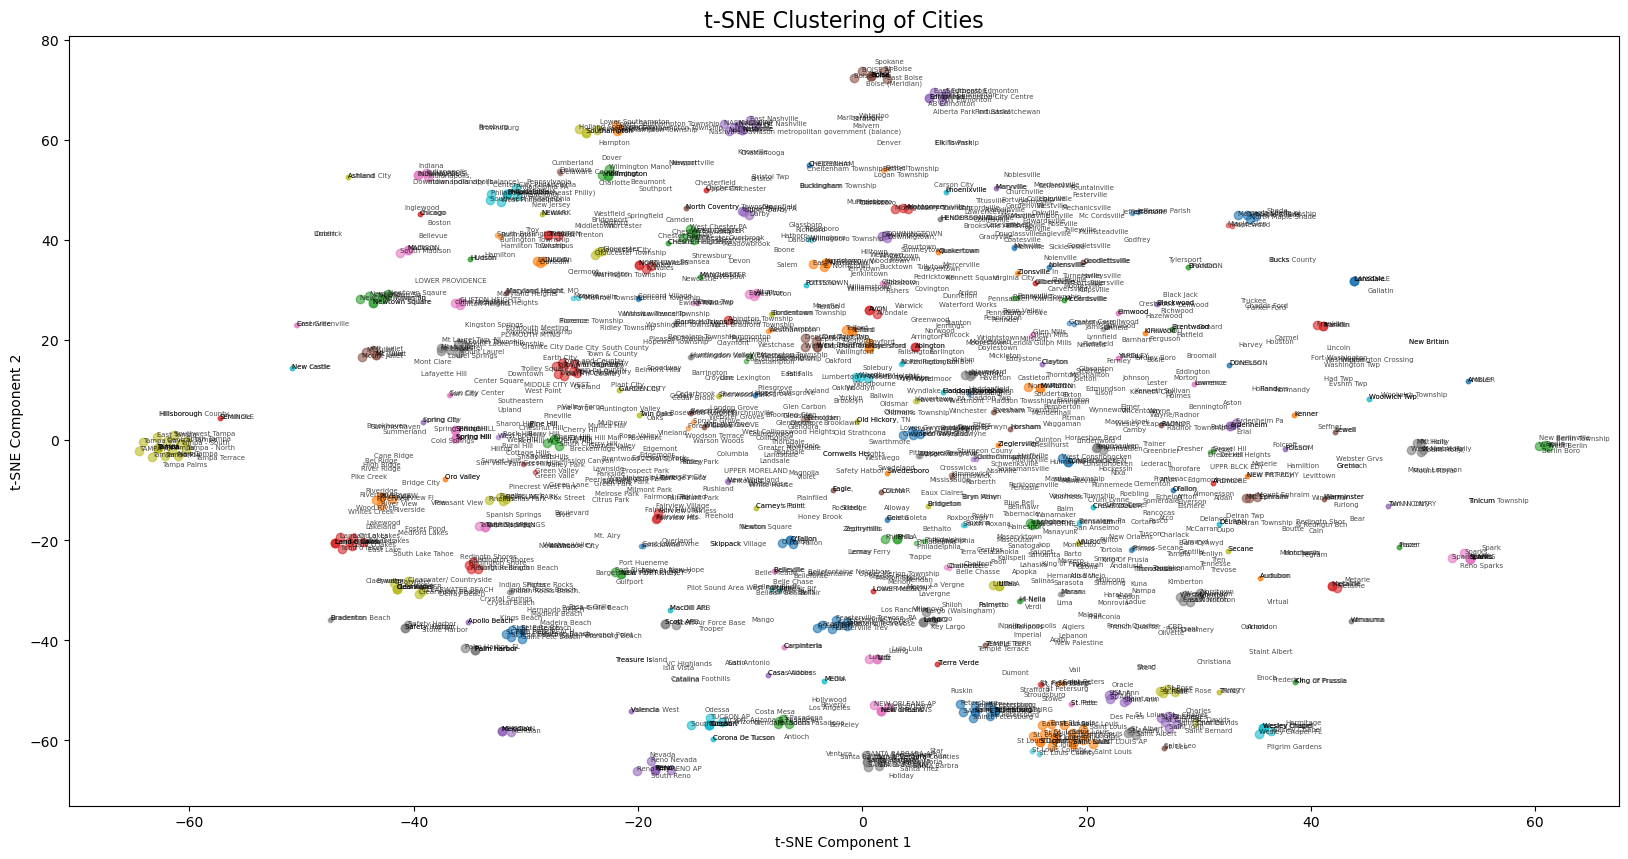

In [29]:
# 可视化聚类
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Step 4: 绘制聚类结果
single_city = []

plt.figure(figsize=(20, 10))
for label in set(labels):
    # 获取当前聚类的点
    cluster_points = embeddings_2d[labels == label]
    # 如果聚类里只有两个点，则跳过
    if len(cluster_points) < 2:
        single_city.append(label)
        continue
    if len(cluster_points) < 3:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", alpha=0.5,s=10)
        continue
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", alpha=0.6)

# 为每个点标注城市名
for i, city in enumerate(city_names):
    # 如果城市名在单个城市列表中，则跳过
    if city in single_city:
        continue
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], city, fontsize=5, alpha=0.7)

plt.title('t-SNE Clustering of Cities', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.legend()
# 输出为png
plt.savefig("city_clustering.png", dpi=300)

In [30]:
# 重新整理business_count和review_count
city_bussiness_count = {}
city_review_count = {}
for city in city_names:
    # 如果城市名在单个城市列表中，则跳过
    if city in single_city:
        continue
    # 获取规范化的城市名称
    canonical_name = alias_dict[city]
    # 更新业务数量和评论数量
    if canonical_name in city_bussiness_count:
        city_bussiness_count[canonical_name] += cities_bussiness_count[city]
        city_review_count[canonical_name] += cities_review_count[city]
    else:
        city_bussiness_count[canonical_name] = cities_bussiness_count[city]
        city_review_count[canonical_name] = cities_review_count[city]

# 将结果转换为DataFrame
city_bussiness_count_df = pd.DataFrame.from_dict(city_bussiness_count, orient='index', columns=['business_count'])
city_review_count_df = pd.DataFrame.from_dict(city_review_count, orient='index', columns=['review_count'])


In [ ]:
city_bussiness_count_df.index.name = 'city_name'
city_review_count_df.index.name = 'city_name'
# 重置索引
city_bussiness_count_df.reset_index(inplace=True)
city_review_count_df.reset_index(inplace=True)
# 保存
city_bussiness_count_df.to_csv("city_bussiness_count.csv", index=False)
city_review_count_df.to_csv("city_review_count.csv", index=False)


In [35]:
#合并
city_count_df = pd.merge(city_bussiness_count_df, city_review_count_df, on='city_name')
# 保存
city_count_df.to_csv("city_count.csv", index=False)
city_count_df

,city_name,business_count,review_count
0,Santa Barbara,3839,263128
1,Affton,36,910
2,Tucson,9268,387769
3,Philadelphia,14585,936728
4,Green Lane,10,107
...,...,...,...
978,Reno Sparks,1,38
979,Charlotte,1,8
980,Key Largo,1,5
981,Slidell,1,18
